### Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

# 2.2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

# 2.3
from sklearn.model_selection import GridSearchCV

# 2.4
from sklearn.model_selection import KFold


### Options

In [18]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [19]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

### Load Data

In [20]:
# defaults excluding NA
na_vals = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
           '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null']

df_raw = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', keep_default_na=False, na_values=na_vals)

df_raw.replace('NA', 'NA_cat', inplace=True) # NA is a category

In [21]:
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Organize Features

In [22]:
# per the TA answer in this post I treat everything with dtype == object as categorical and 
# everything with dtype != object as continuous: https://piazza.com/class/jop0ywdqsmv6r3?cid=179
msk = (df_raw.dtypes == object)
categorical = msk[msk].index.tolist()
continuous = msk[~msk].index.tolist()
categorical.remove('Churn')
target = ['Churn']

len(categorical) + len(continuous) + len(target) == df_raw.shape[1]


True

In [23]:
df = df_raw.copy()

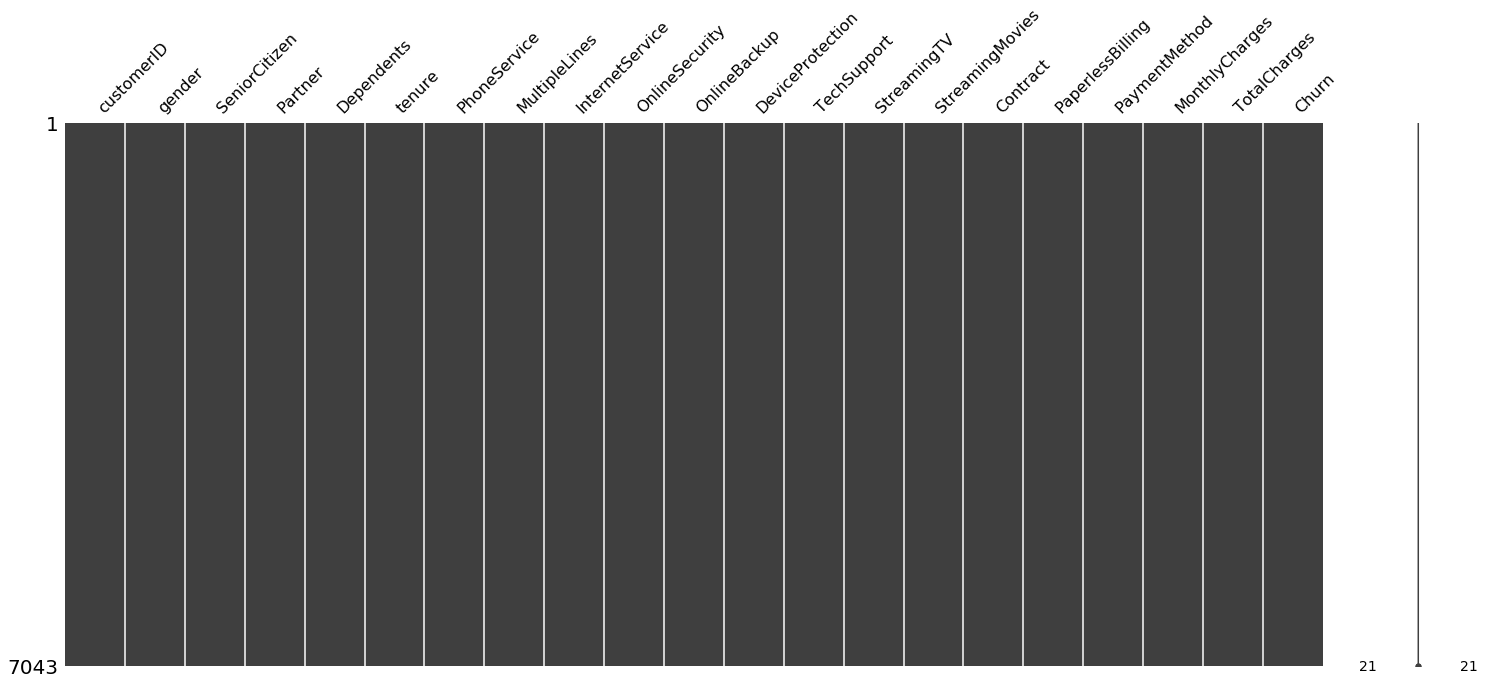

In [24]:
msno.matrix(df)

### 2.1 Visualize the univariate distribution of each continuous feature, and the distribution of the target.

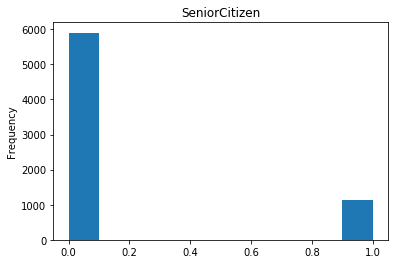

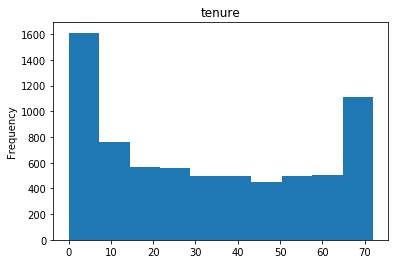

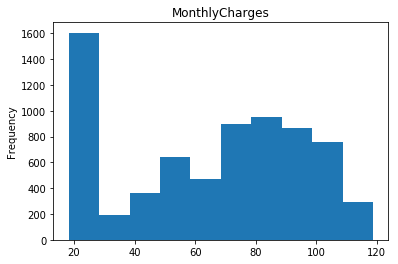

In [25]:
for col in continuous:
    df[col].plot(kind='hist', title=col)
    plt.show()

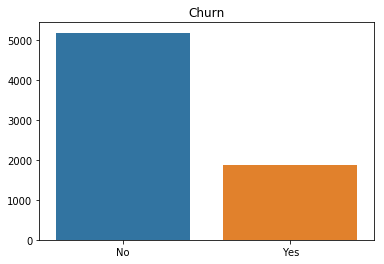

In [26]:
sns.barplot(x=df['Churn'].value_counts().index.tolist(), y=df['Churn'].value_counts().tolist())
plt.title(f'Churn')
plt.show()

We appear to have imbalanced classes in our target variable. There are methods for handling this such as weighting and subsampling but we were not asked to address this so I have omitted dealing with the imbalanced classes for this assignment.

### 2.2 Split data into training and test set. Build a pipeline for dealing with categorical variables. Evaluate Logistic Regression, linear support vector machines and nearest centroids using cross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [34]:
df_train = df.sample(frac=.9)
df_test = df[~df.index.isin(df_train.index.tolist())]

In [35]:
preprocess = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), 
                   StandardScaler()), continuous),
    (make_pipeline(SimpleImputer(strategy='most_frequent'), 
                   OneHotEncoder(handle_unknown='ignore', sparse=False)), categorical),
    remainder='passthrough'
)
pipes = {}

In [36]:
pipes['logistic'] = make_pipeline(preprocess, LogisticRegression(solver='liblinear'))
pipes['svm'] = make_pipeline(preprocess, LinearSVC())
pipes['nc'] = make_pipeline(preprocess, NearestCentroid())

In [37]:
mean_scores = {}
X_train = df_train.drop(['Churn'], axis=1)
y_train = df_train['Churn']

In [38]:
for name, pipe in pipes.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    mean_scores[name] = np.mean(scores)

In [39]:
mean_scores

{'logistic': 0.8034359969481315,
 'svm': 0.8009128344245389,
 'nc': 0.7248781165863183}

The logistic regression and SVM are relatively similiar.  Without scaling, logistic is better but with scaling, the SVM and logistic regression are about the same.  While scaling slightly improves the Nearest Centroid, in both cases it performs quite a bit worse than logistic regression or SVM.

#### without scaling
* 'logistic': 0.8031242736433561,
* 'svm': 0.7602235485292081,
* 'nc': 0.7199871588616393

#### with scaling
* 'logistic': 0.8034359969481315,
* 'svm': 0.8009128344245389,
* 'nc': 0.7248781165863183

### 2.3 Tune the parameters using GridSearchCV. Do the results improve? Visualize the performance as function of the parameters for all three models.

In [40]:
X_test = df_test.drop(['Churn'], axis=1)
y_test = df_test['Churn']

In [41]:
logistic_params = {'logisticregression__C': np.logspace(-3, 3, 13)}
logistic_grid = GridSearchCV(pipes['logistic'], logistic_params, cv=5, return_train_score=True)
logistic_grid.fit(X_train, y_train)
print(logistic_grid.best_params_)
print(logistic_grid.best_score_)
print(logistic_grid.score(X_test, y_test))

{'logisticregression__C': 3.1622776601683795}
0.8050165641268339
0.7926136363636364


In [42]:
svm_params = {'linearsvc__C': np.logspace(-3, 3, 13)}
svm_grid = GridSearchCV(pipes['svm'], svm_params, cv=5, return_train_score=True)
svm_grid.fit(X_train, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)
print(svm_grid.score(X_test, y_test))

{'linearsvc__C': 0.0031622776601683794}
0.804070042593469
0.796875


In [43]:
nc_params = {'nearestcentroid__shrink_threshold': np.logspace(-3, 3, 13)}
nc_grid = GridSearchCV(pipes['nc'], nc_params, cv=5, return_train_score=True)
nc_grid.fit(X_train, y_train)
print(nc_grid.best_params_)
print(nc_grid.best_score_)
print(nc_grid.score(X_test, y_test))

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7368670137245622
0.6619318181818182


The results improve with GridSearchCV for all three, but not by much. The best CV score for Logistic Regression improves slightly from 0.803 to 0.805. SVM slightly from 0.800 to 0.804. And Nearest Centroid from 0.724 to 0.736.  Nearest Centroid seems to improve the most, however with a larger search space the results for all through could possibly improve even more.

In [44]:
logistic_df = pd.melt(pd.DataFrame({
    'C': logistic_grid.cv_results_['param_logisticregression__C'].tolist(),
    'Training Score': logistic_grid.cv_results_['mean_train_score'].tolist(),
    'Cross-validation Score': logistic_grid.cv_results_['mean_test_score'].tolist()
    
}), id_vars=['C'])

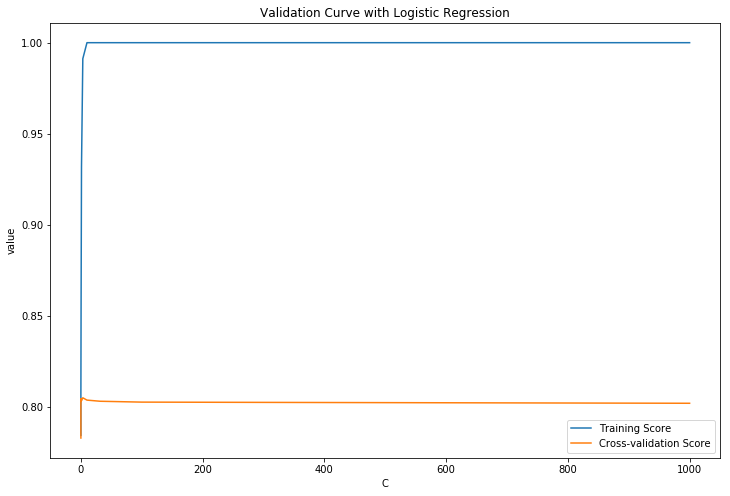

In [45]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='C', y='value', hue='variable', data=logistic_df)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.title('Validation Curve with Logistic Regression')
plt.show()

In [46]:
svm_df = pd.melt(pd.DataFrame({
    'C': svm_grid.cv_results_['param_linearsvc__C'].tolist(),
    'Training Score': svm_grid.cv_results_['mean_train_score'].tolist(),
    'Cross-validation Score': svm_grid.cv_results_['mean_test_score'].tolist()
    
}), id_vars=['C'])

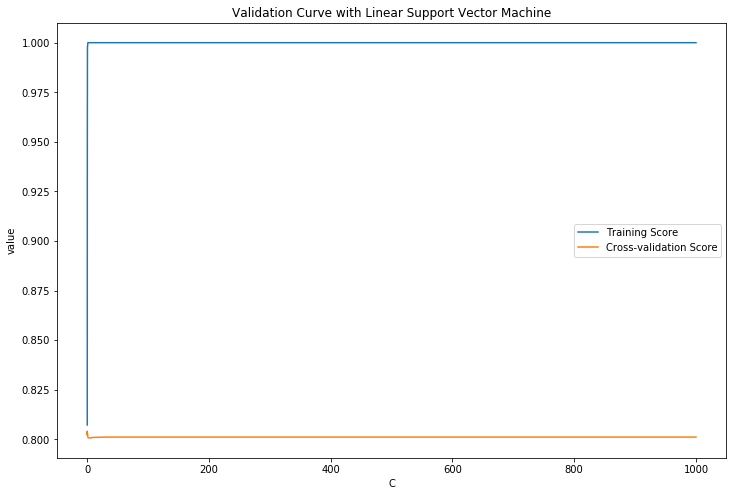

In [47]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='C', y='value', hue='variable', data=svm_df)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.title('Validation Curve with Linear Support Vector Machine')
plt.show()

In [48]:
nc_df = pd.melt(pd.DataFrame({
    'shrinkage': nc_grid.cv_results_['param_nearestcentroid__shrink_threshold'].tolist(),
    'Training Score': nc_grid.cv_results_['mean_train_score'].tolist(),
    'Cross-validation Score': nc_grid.cv_results_['mean_test_score'].tolist()
    
}), id_vars=['shrinkage'])

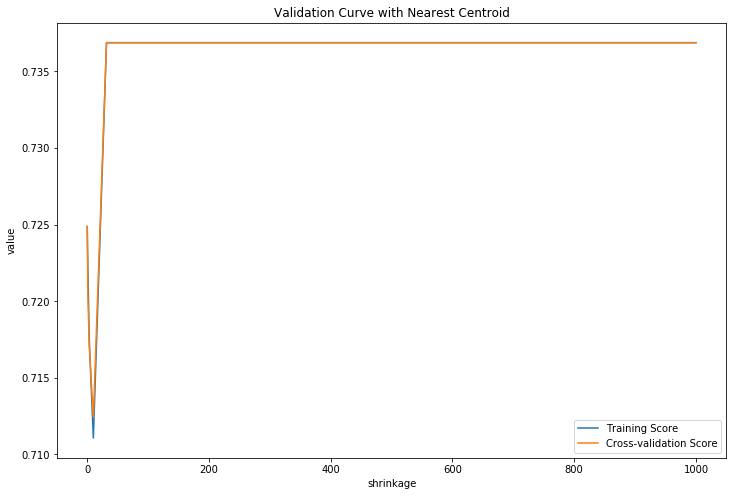

In [49]:
plt.figure(figsize=(12, 8))
ax = sns.lineplot(x='shrinkage', y='value', hue='variable', data=nc_df)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.title('Validation Curve with Nearest Centroid')
plt.show()

### 2.4 Change the cross-validation strategy from 'stratified k-fold' to 'kfold' with shuffling. Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?



In [62]:
df_train_seed = df.sample(frac=.9, random_state=42)
df_test_seed = df[~df.index.isin(df_train.index.tolist())]

X_train_seed = df_train_seed.drop(['Churn'], axis=1)
y_train_seed = df_train_seed['Churn']

X_test_seed = df_test_seed.drop(['Churn'], axis=1)
y_test_seed = df_test_seed['Churn']

k_fold = KFold(n_splits=5, shuffle=True, random_state=1)

In [63]:
logistic_params = {'logisticregression__C': np.logspace(-3, 3, 13)}
logistic_grid = GridSearchCV(pipes['logistic'], logistic_params, cv=k_fold, return_train_score=True)
logistic_grid.fit(X_train_seed, y_train_seed)
print(logistic_grid.best_params_)
print(logistic_grid.best_score_)
print(logistic_grid.score(X_test_seed, y_test_seed))

{'logisticregression__C': 0.1}
0.8039122890045749
0.8139204545454546


In [64]:
svm_params = {'linearsvc__C': np.logspace(-3, 3, 13)}
svm_grid = GridSearchCV(pipes['svm'], svm_params, cv=k_fold, return_train_score=True)
svm_grid.fit(X_train_seed, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)
print(svm_grid.score(X_test_seed, y_test_seed))

{'linearsvc__C': 0.001}
0.7368670137245622
0.7144886363636364


In [65]:
nc_params = {'nearestcentroid__shrink_threshold': np.logspace(-3, 3, 13)}
nc_grid = GridSearchCV(pipes['nc'], nc_params, cv=k_fold, return_train_score=True)
nc_grid.fit(X_train_seed, y_train_seed)
print(nc_grid.best_params_)
print(nc_grid.best_score_)
print(nc_grid.score(X_test_seed, y_test_seed))

{'nearestcentroid__shrink_threshold': 31.622776601683793}
0.7321344060577378
0.6619318181818182


In general, the parameters for Nearest Centroid do not appears to change regardless of the cross validation strategy or random seeds.  However, the parameters for Logistic Regression and SVM appear to change both depending on the cross validation strategy as well as the random seeds for splitting and for shuffling. A few examples are below for different cross validation strategies and random seeds. However, you will see that in this example the SVM parameter doesn't change when only the shuffle random seed is changed, meaning sometimes even if the seed is different it apparently may find the same parameters.

#### Stratefied K-fold

* Logistic Regression C: 3.1622776601683795
* Support Vector Machine C: 0.0031622776601683794
* Nearest Centroid Shrink: 31.622776601683793

#### K-fold, Split Random Seed 42, Shuffle Random Seed 42

* Logistic Regression C: 1.0
* Support Vector Machine C: 0.001
* Nearest Centroid Shrink: 31.622776601683793

#### K-fold, Split Random Seed 1, Shuffle Random Seed 42

* Logistic Regression C: 0.01
* Support Vector Machine C: 0.1
* Nearest Centroid Shrink: 31.622776601683793

#### K-fold, Split Random Seed 42, Shuffle Random Seed 1

* Logistic Regression C: 0.1
* Support Vector Machine C: 0.001
* Nearest Centroid Shrink: 31.622776601683793

### 2.5 Visualize the coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [66]:
log_res = logistic_grid.best_estimator_.named_steps['logisticregression']
logistic_coefficients = log_res.coef_.flatten().tolist()

col_trans = logistic_grid.best_estimator_.named_steps['columntransformer']
logistic_ohe = col_trans.transformers_[1][1].steps[1][1].get_feature_names().tolist()

logistic_feature_names = continuous + logistic_ohe
print(len(logistic_feature_names) == len(logistic_coefficients))

logistic_feature_importance = dict(zip(logistic_feature_names, logistic_coefficients))

True


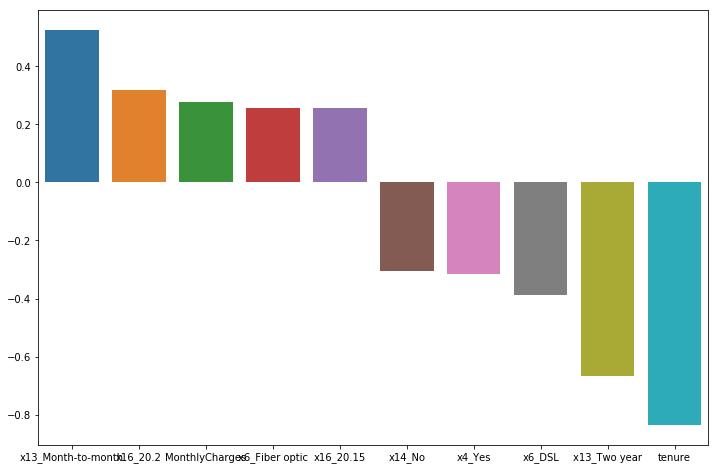

In [67]:
logistic_top_scores = sorted(logistic_feature_importance, 
                             key=logistic_feature_importance.get, 
                             reverse=True)

logistic_x = []
logistic_y = []
for col in logistic_top_scores[:5] + logistic_top_scores[-5:]:
    logistic_x.append(col)
    logistic_y.append(logistic_feature_importance[col])

plt.figure(figsize=(12, 8))
sns.barplot(x=logistic_x, y=logistic_y)

In [68]:
lin_svc = svm_grid.best_estimator_.named_steps['linearsvc']
svm_coefficients = lin_svc.coef_.flatten().tolist()

col_trans = svm_grid.best_estimator_.named_steps['columntransformer']
svm_ohe = col_trans.transformers_[1][1].steps[1][1].get_feature_names().tolist()

svm_feature_names = continuous + svm_ohe
print(len(svm_feature_names) == len(svm_coefficients))

svm_feature_importance = dict(zip(svm_feature_names, svm_coefficients))



True


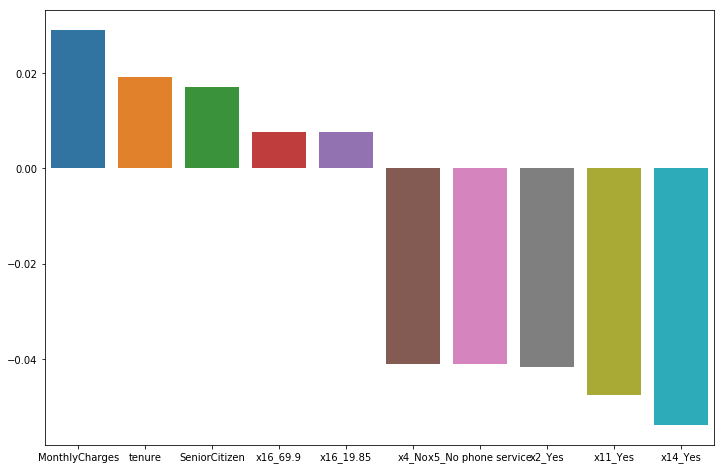

In [69]:
svm_top_scores = sorted(svm_feature_importance, 
                        key=svm_feature_importance.get, 
                        reverse=True)

svm_x = []
svm_y = []
for col in svm_top_scores[:5] + svm_top_scores[-5:]:
    svm_x.append(col)
    svm_y.append(svm_feature_importance[col])

plt.figure(figsize=(12, 8))
sns.barplot(x=svm_x, y=svm_y)